## Import Cleaned Data

__DataFrames:__  
df_model - df with all the features (independent festures + Target)  
x - df with all independent features
y - df with dependent feature  
x_train - df with training data from x  
x_train_out - df with training data from x with outliers treatment applied  
x_test - df with test data from x  
x_test_out - df with test data from x with outliers treatment applied  



In [1]:
import sys
#set timer
from time import time 

start_time = time()

#import sys library to add personal code 

#define path to get paths
pathsPath = r'D:\Code\RD\Paths'
sys.path.insert(1, pathsPath)

#import paths
import definePaths as pathsMain

#set paths
fmpPath = pathsMain.get_FMPapi_path()
functions_path = pathsMain.get_insertMlFunctions_path()

#create a list of paths
pathList = [fmpPath, functions_path]
#set personal code paths
for index, path in enumerate(pathList):
    id_ = index +1
    sys.path.insert(id_, path)

sys.path.insert(4, r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM')

import Visualizations_Functions as viz 
import Classification_CV as class_cv
import DataPreparation as preprocess 
import FeatureExtraction as ft_extract 
import DataScalling as scalling
import FeatureSelection as ft_selection
import importCleanedData as importData
import importSubsets as subsets

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
# from tensorflow import keras

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

#set preferences
sns.set_style('whitegrid')

#set color for graphs
#set color for graphs
palette = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]

dir = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample'
df_model_skew,df_target = importData.importCleanedData_skew(dir=dir,)


#split data
date = '2018-01-01'
#split data without transformation
x_train,x_train_out,x_test, x_test_out,y_train_dict ,y_test_dict, y_train,y_test = importData.splitData_(df_model_skew, date) 


#set columns
ratio_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Ratio'))]
shares_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Share'))]
margin_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Margin'))]
turnover_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('Turnover'))]
dividend_cols = df_model_skew.columns[(df_model_skew.columns.str.contains('dividend'))]

Nr of rows:
72538


#### Analyze returns distribution

Year: 2018
Quarter: 3


,mean,std
size_50,0.071416,0.030302
size_200,0.071560,0.014957
size_500,0.071471,0.008464


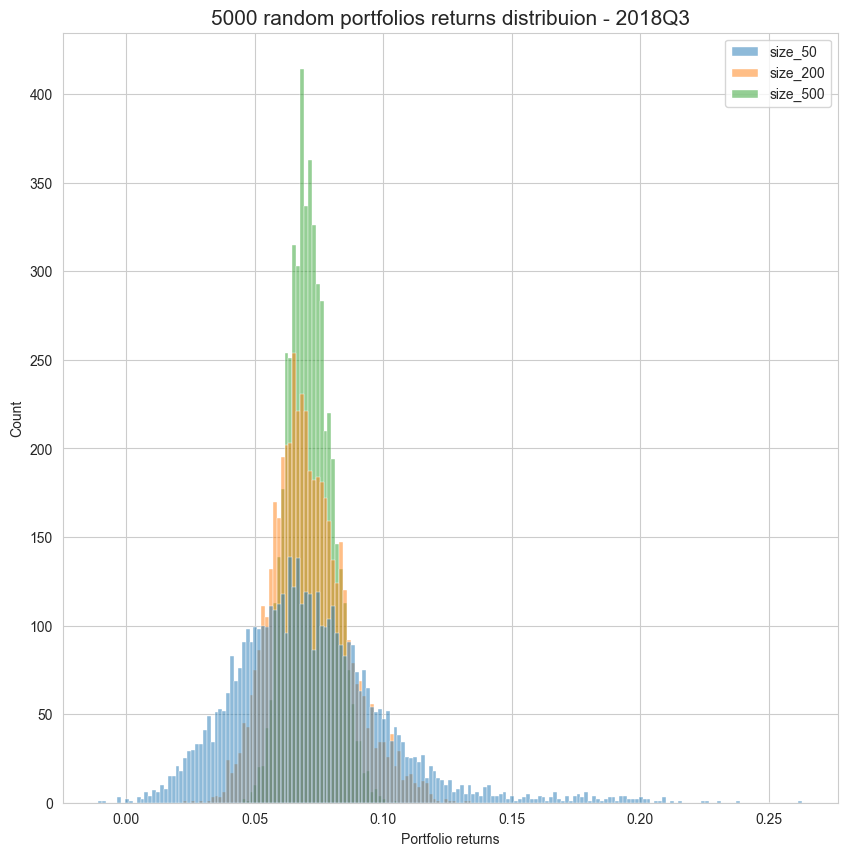

In [63]:
 p = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\SampleData\Sample\Target_CAPM.csv'
df_returns = pd.read_csv(p)[['symbol','futDate','stockQuarterlyReturns']]
df_returns['quarter'] = pd.to_datetime(df_returns.futDate).dt.quarter
df_returns['year'] = pd.to_datetime(df_returns.futDate).dt.year

year = 2018
df_returns = df_returns.loc[df_returns['year']==year]

n_port = 5000
n1,n2, n3 = 50,200, 500
data_list = []
for quarter in df_returns.quarter.unique()[:1]:
    df_filter = df_returns.loc[df_returns.quarter == quarter]
    for iter_ in np.arange(0,n_port):
        data_dict = dict()
        data_dict['quarter'] = quarter
        data_dict[f'size_{n1}'] = df_filter.sample(n1)['stockQuarterlyReturns'].mean()
        data_dict[f'size_{n2}'] = df_filter.sample(n2)['stockQuarterlyReturns'].mean()
        data_dict[f'size_{n3}'] = df_filter.sample(n3)['stockQuarterlyReturns'].mean()
        data_list.append(data_dict)

df_analysis = pd.DataFrame(data_list).set_index(['quarter'])
quarter = df_analysis.reset_index()['quarter'].unique()[0]

print(f'Year: {year}')
print(f'Quarter: {quarter}')
plt.figure(figsize = (10,10))
sns.histplot(df_analysis)
plt.xlabel('Portfolio returns')

title = f'{n_port} random portfolios returns distribuion - {year}Q{quarter}'
plt.title(title, size = 15)

desc = df_analysis.describe().T[['mean','std']]
display(desc)



path = r'D:\Thesis Reseearch\Research\Thesis\Tables\returnsDistribution'
name_plot = f'{path}\\{title}.png'
plt.savefig(name_plot, dpi=300)

desc.to_csv(f'{path}\\returnsDistribution.csv')


    

### Final Subsets

In [8]:
mi_subset_dict = {'Target_0':['numberOfShares',
  'costOfRevenue_TTM',
  'QoQ_costAndExpenses',
  'incomeBeforeTaxRatio',
  'goodwillAndIntangibleAssets',
  'earnings',
  'accountsPayables',
  'fixedAssetTurnover',
  'excessReturn_84',
  'netIncome_bin',
  'ebtPerEbit',
  'netIncome_cf',
  'YoY_netIncome',
  'totalOtherIncomeExpensesNet',
  'Volatility_42',
  'operatingIncome',
  'dividendPayoutRatio',
  'cashAtEndOfPeriod',
  'depreciationAndAmortization',
  'cashFlowCoverageRatios',
  'purchasesOfInvestments',
  'assetTurnover',
  'eps',
  'commonStock'],
                  
  'Target_0.15': ['Volatility_84',
  'Volatility_21',
  'operatingIncome',
  'costAndExpenses_TTM',
  'netIncome_bin',
  'dividendPayoutRatio',
  'totalDividend',
  'dividend',
  'netIncome_TTM',
  'dividendsPaid',
  'otherCurrentLiabilities',
  'dividendYield',
  'totalAssets',
  'eps_TTM',
  'otherNonCurrentAssets',
  'totalLiabilitiesAndTotalEquity',
  'otherCurrentAssets',
  'marketcap_bin',
  'netCashUsedForInvestingActivites',
  'goodwill',
  'totalNonCurrentAssets']}

lasso_subset_dict = {'Target_0':['revenue',
  'costOfRevenue',
  'otherExpenses',
  'interestIncome',
  'weightedAverageShsOut',
  'cashAndShortTermInvestments',
  'otherCurrentAssets',
  'totalCurrentAssets',
  'goodwill',
  'intangibleAssets',
  'longTermInvestments',
  'otherAssets',
  'deferredRevenue',
  'otherCurrentLiabilities',
  'deferredRevenueNonCurrent',
  'totalNonCurrentLiabilities',
  'capitalLeaseObligations',
  'preferredStock',
  'totalInvestments',
  'netIncome_cf',
  'depreciationAndAmortization_cf',
  'deferredIncomeTax',
  'stockBasedCompensation',
  'inventory_cf',
  'netCashProvidedByOperatingActivities',
  'salesMaturitiesOfInvestments',
  'otherFinancingActivites',
  'effectOfForexChangesOnCash',
  'daysOfPayablesOutstanding',
  'netProfitMargin',
  'freeCashFlowPerShare',
  'capitalExpenditureCoverageRatio',
  'priceEarningsRatio',
  'close',
  'totalDividend',
  'operatingIncome_TTM',
  'eps_TTM',
  'YoY_ebitda',
  'YoY_operatingIncome',
  'YoY_eps'],
                     
  'Target_0.15':['revenue',
  'costOfRevenue',
  'generalAndAdministrativeExpenses',
  'sellingAndMarketingExpenses',
  'interestIncome',
  'operatingIncome',
  'weightedAverageShsOut',
  'cashAndShortTermInvestments',
  'otherCurrentAssets',
  'totalCurrentAssets',
  'goodwill',
  'taxAssets',
  'totalAssets',
  'accountPayables',
  'longTermDebt',
  'deferredRevenueNonCurrent',
  'deferredTaxLiabilitiesNonCurrent',
  'capitalLeaseObligations',
  'commonStock',
  'netIncome_cf',
  'depreciationAndAmortization_cf',
  'deferredIncomeTax',
  'commonStockIssued',
  'effectOfForexChangesOnCash',
  'freeCashFlow',
  'daysOfInventoryOutstanding',
  'daysOfPayablesOutstanding',
  'companyEquityMultiplier',
  'operatingCashFlowPerShare',
  'capitalExpenditureCoverageRatio',
  'priceEarningsRatio',
  'priceEarningsToGrowthRatio',
  'close',
  'totalDividend',
  'researchAndDevelopmentExpenses_TTM',
  'YoY_netIncome']}

### PCA

In [13]:
def PCA (data,indexes, n_components):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA as PCA
    
    
    data.reset_index()
    metric_features = list(data.select_dtypes(include=np.number).set_index(data.index).columns)
    x = data.loc[:,metric_features]

    print(f'Nr of input features for PCA {len(metric_features)}')  
    
    stand = StandardScaler().fit_transform(x)
    s = pd.DataFrame(stand, columns= x.columns)
    s.set_index(data.index)
    
    pca = PCA(n_components=n_components,random_state=0)
    components = pd.DataFrame(pca.fit_transform(s), index = data.index)
    
    df = pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1))
    
    PC = pca
    plt.figure()

    cum_sum = PC.explained_variance_ratio_.cumsum()
    exp_var = PC.explained_variance_
    cov = PC.get_covariance()
    
    #plot PCA report
    plt.figure(figsize=(20,10))
    ax1 = plt.subplot(1,2,1)
    title = 'Eigenvalues of each component'
    sns.lineplot(data = df.loc[:,['Eigenvalue']],ax=ax1)
    plt.axhline(1,ls='--')
    ax1.set_title(title, size = 15, weight = 'bold')
    ax1.set_ylabel('Eigenvalue',size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    ax1.set_xlabel('Nr of Pricipal Components',size = 15,weight = 'bold')
    
    ax2 = plt.subplot(1,2,2)
    title = 'Cumulative % of total variance explained by the components'
    sns.lineplot(data = df.loc[:,['Cumulative','Proportion']],ax=ax2)
    ax2.set_title(title, size = 15,weight = 'bold')
    ax2.set_ylabel('Cumulative %',size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    ax2.set_xlabel('Nr of Pricipal Components',size = 15,weight = 'bold')
    plt.tight_layout()
    path = r'D:\Thesis Reseearch\Asset Allocation - Clean\Asset-Allocation\Long-Term-CAPM\Exports\Exploration'
    full_title = 'PCA_Report'
    name_plot = f'{path}\\{full_title}.png'
    plt.savefig(name_plot, dpi=600)
    plt.show()
    
    print('The variance explained by each component is: ' + str(exp_var))
    print('The total variance explained by the components is: '+ str(sum(PC.explained_variance_ratio_)))
    
    for i in components.columns:
        components.rename(columns={i: f'PC_{i}'},inplace=True)
    
    return(df, components,PC)


def PCA_Assess_loadings (data, components, n_components):
    df = pd.concat([data, components], axis=1)
    loadings = df.corr().iloc[:-n_components,-n_components:]
    
    
    def _color_red_or_green(val):
        if val < -0.45:
            color = 'background-color: red'
        elif val > 0.45:
            color = 'background-color: green'
        else:
            color = ''
        return color
    return(loadings.style.applymap(_color_red_or_green))

#### With Indicators + Dummy Features

Nr of input features for PCA 355
Nr of input features for PCA 355


<Figure size 640x480 with 0 Axes>

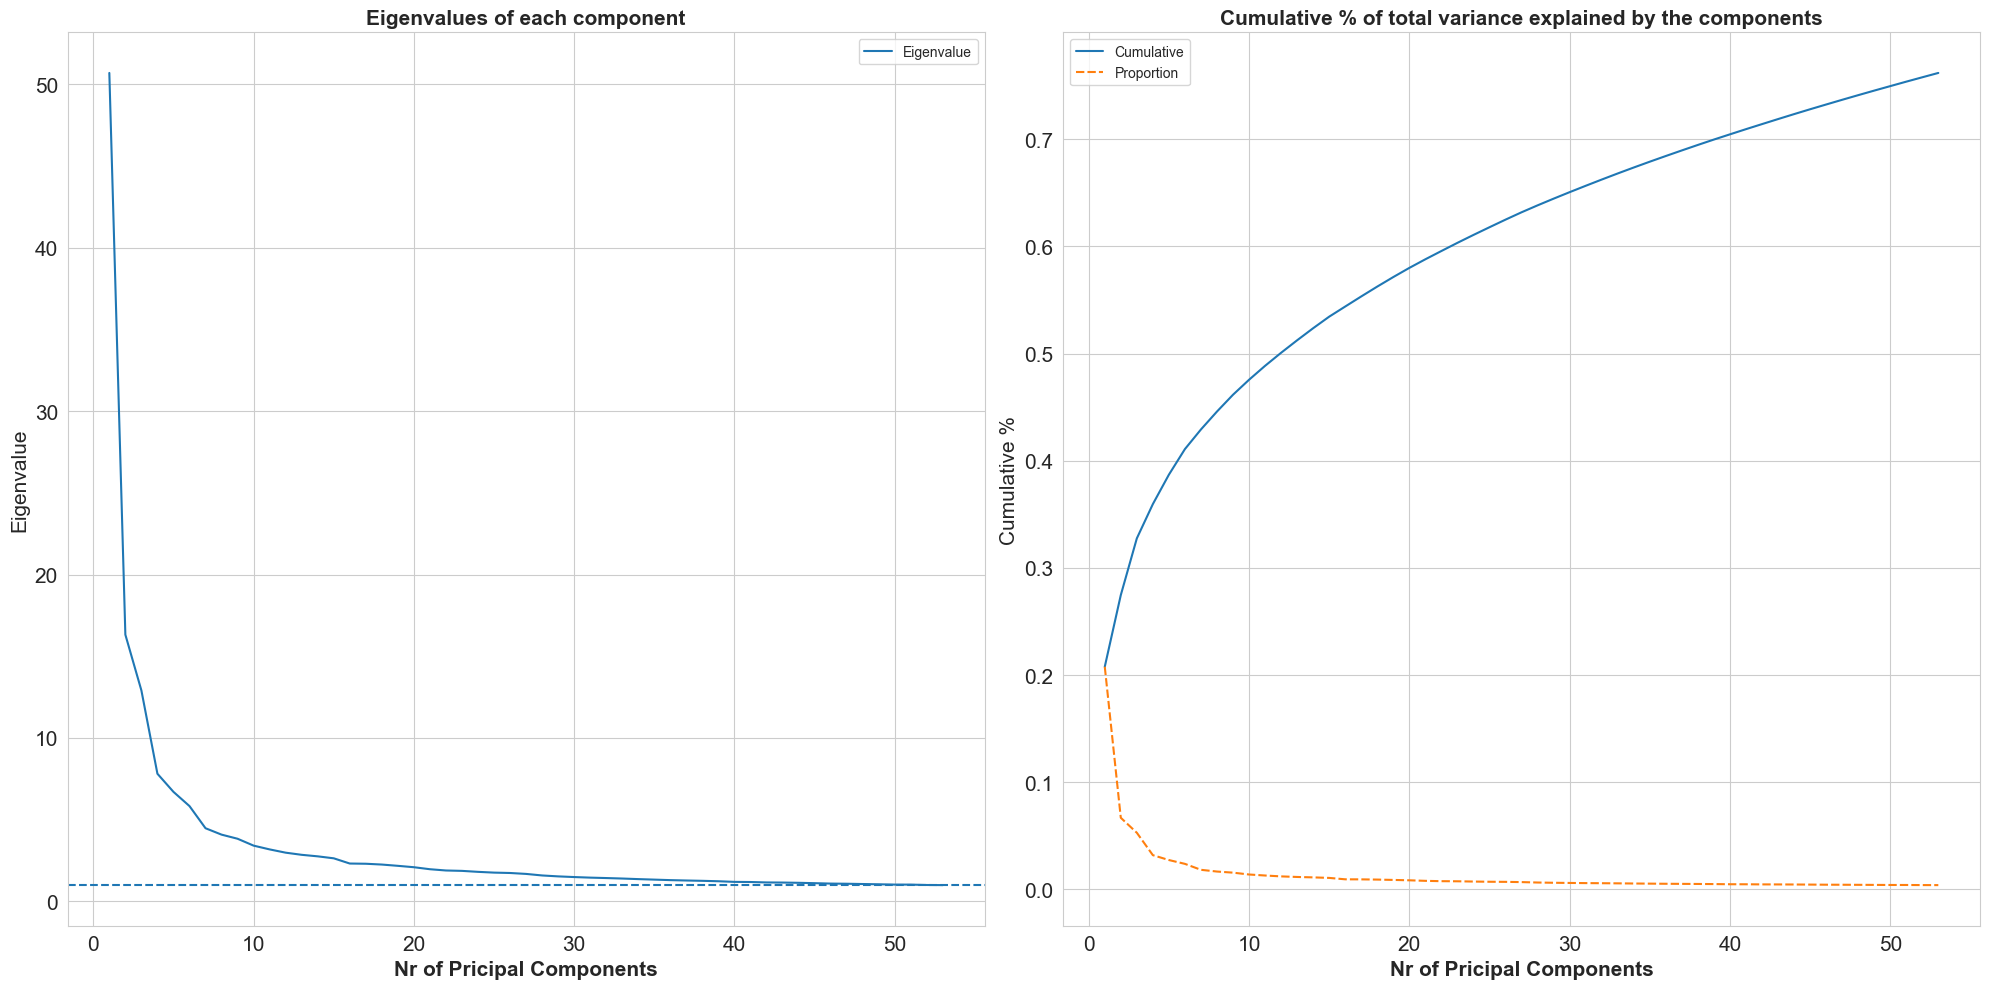

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001962


In [14]:
metric_features = list(x_train_out.select_dtypes(include=np.number).set_index(x_train_out.index).columns)
x_train_pca= x_train_out[metric_features].copy()

print(f'Nr of input features for PCA {len(metric_features)}')  

df_pca, components_pca, pca_model = PCA(x_train_out.fillna(0),x_train_out.index,53)

Nr of input features for PCA 355
Nr of input features for PCA 355


<Figure size 640x480 with 0 Axes>

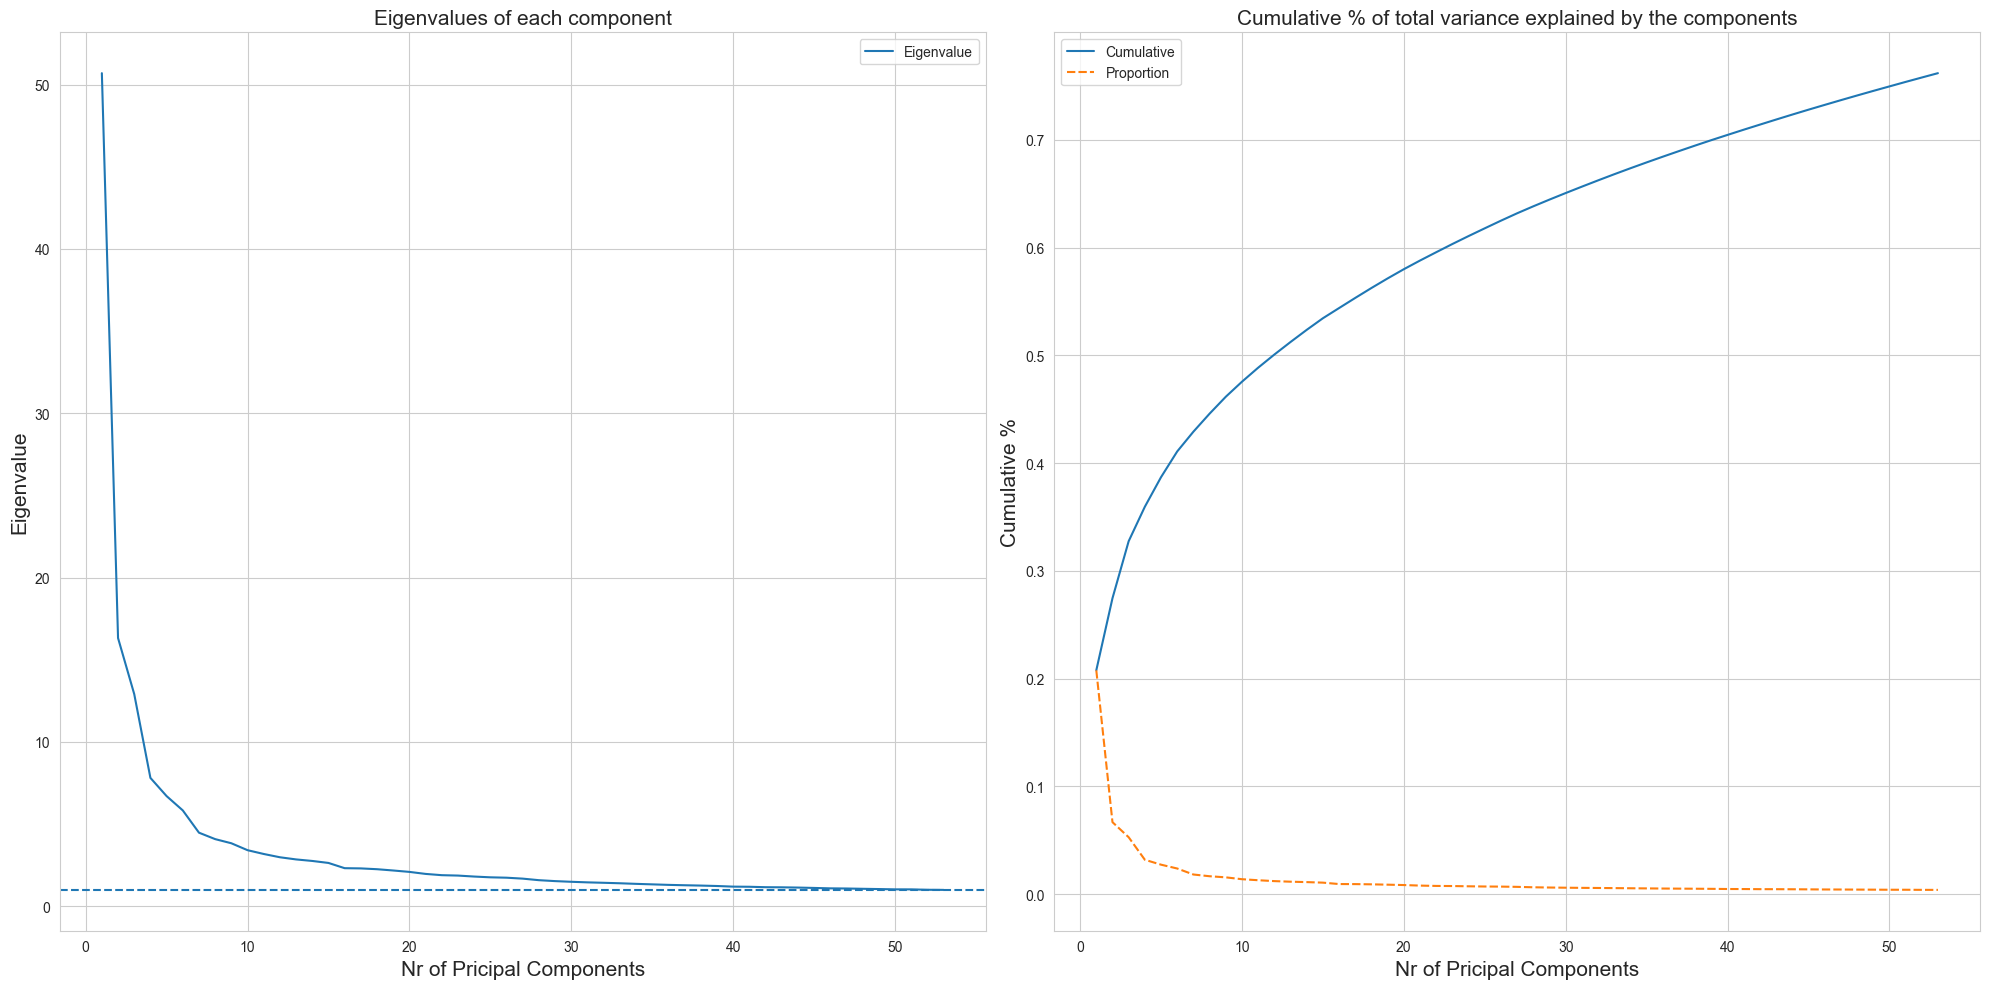

The variance explained by each component is: [50.70262543 16.3180414  12.90616231  7.80559243  6.69692605  5.82614766
  4.47015907  4.07836541  3.82626867  3.40508117  3.17395217  2.97398597
  2.84255924  2.7491931   2.6284572   2.30920491  2.29580116  2.24676716
  2.1685526   2.08344875  1.96058327  1.88331954  1.85945512  1.79999003
  1.75303096  1.72999438  1.67342676  1.57892838  1.52235707  1.48115797
  1.44613583  1.42029951  1.39091026  1.35520895  1.32448072  1.29342424
  1.27059382  1.25051426  1.2247642   1.18608517  1.17810508  1.15156743
  1.14454538  1.12935887  1.10669478  1.0815426   1.07222534  1.05458183
  1.03848544  1.01988948  1.01877496  0.99533768  0.98807987]
The total variance explained by the components is: 0.7618344466001962


In [19]:
metric_features = list(x_train_out.select_dtypes(include=np.number).set_index(x_train_out.index).columns)
x_train_pca= x_train_out[metric_features].copy()

print(f'Nr of input features for PCA {len(metric_features)}')  

df_pca, components_pca, pca_model = PCA(x_train_out.fillna(0),x_train_out.index,53)

##### Test model performance when using 53 PC - fitted with indicators + dummies

When comparing the performance of Principal Component feature set fitted with continuous indicators and dummy variables related to sector and industry, which resulted in 53 Principal Components (PC53), with the performance of a Principal Component fitted only with continuous indicators, resullting in 40 PC (PC40), it's possible to conclude that for Target 0, the PCA that included dummy features outperformed when compared to the PCA fitted only with continuous indicators. Two different models were tested during this experiment, namely Logistic Regression and LGBM with the Logistic Regression presenting an accuracy of 0.536066 for the PC53 and 0.534754 for PC40 and the LGBM presenting an accuracy of 0.537474 for the PC53 and 0.535724 for the PC40 respectively. Although dummy variables should be avoided when using Principal Components, mainly due to interpretability issues, since the project focuses mainly on predictive power, the PCA fitted with both continuous features and dummy variables related to sector and industry will be used throughout the project.

- LGBM - Target 0

In [20]:
model = lgb.LGBMClassifier(learning_rate=0.2,
                               max_depth=2,
                               n_estimators=50,
                               random_state=0)

x = components_pca
y = y_train_dict['Target_0']


print(f'Nr of input features for the model: {x.shape[1]}')
assess_lgbm_53 = class_cv.validateModel(x,
                                y,
                                model=model ,
                                scaler=True ,
                                over_sampling=False,
                                predictions=False,
                                cv_type='stratKfold',
                                scaler_type='stand',
                                train_size=10,
                                test_size=1,
                                gap=0)


assess_lgbm_53['scores'].mean()

Nr of input features for the model: 53
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
[LightGBM] [Info] Number of positive: 24512, number of negative: 22801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 47313, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518082 -> initscore=0.072358
[LightGBM] [Info] Start training from score 0.072358
[LightGBM] [Info] Number of positive: 24512, number of negative: 22801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13515
[LightGBM] [Info] Number of data points in the train set: 47313, number of used features: 53
[LightGBM

accuracy_train     0.568584
f1_train           0.637380
recall_train       0.731869
precision_train    0.564519
auc_train          0.562461
accuracy_test      0.537474
f1_test            0.609408
recall_test        0.700457
precision_test     0.541682
auc_test           0.531359
dtype: float64

- Logistic Regression

In [21]:
model = LogisticRegression(random_state=0,
                              solver='liblinear')

x = components_pca
y = y_train_dict['Target_0']


print(f'Nr of input features for the model: {x.shape[1]}')
assess_lr_53 = class_cv.validateModel(x,
                                y,
                                model=model ,
                                scaler=True ,
                                over_sampling=False,
                                predictions=False,
                                cv_type='stratKfold',
                                scaler_type='stand',
                                train_size=10,
                                test_size=1,
                                gap=0)


assess_lr_53['scores'].mean()

Nr of input features for the model: 53
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.548557
f1_train           0.618262
recall_train       0.705685
precision_train    0.550152
auc_train          0.542665
accuracy_test      0.536066
f1_test            0.600897
recall_test        0.684193
precision_test     0.542350
auc_test           0.530511
dtype: float64


accuracy_train     0.548557
f1_train           0.618262
recall_train       0.705685
precision_train    0.550152
auc_train          0.542665
accuracy_test      0.536066
f1_test            0.600897
recall_test        0.684193
precision_test     0.542350
auc_test           0.530511
dtype: float64

#### With Indicators

Nr of input features for PCA 209
Nr of input features for PCA 209


<Figure size 640x480 with 0 Axes>

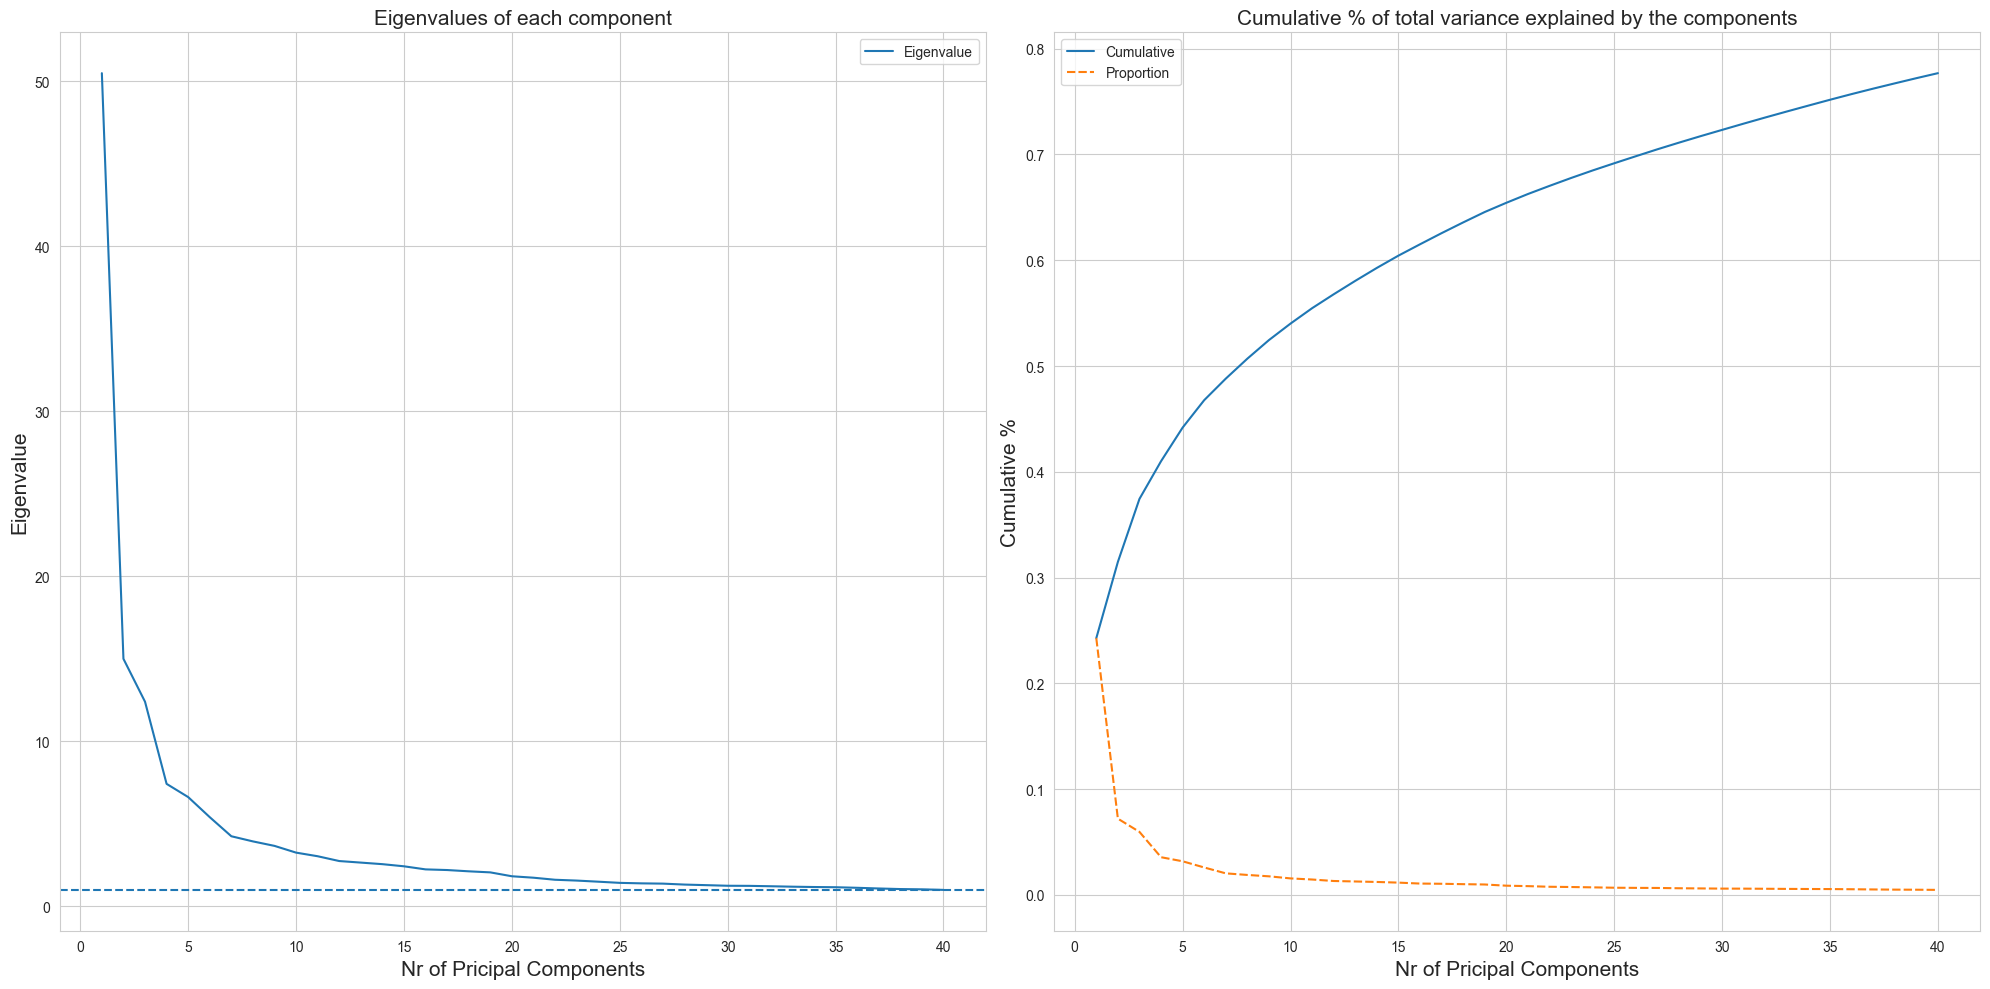

The variance explained by each component is: [50.48635562 14.99181464 12.39106567  7.41249345  6.61089706  5.39342629
  4.23694713  3.925147    3.65341919  3.24474635  3.02571317  2.73462981
  2.64032401  2.54546939  2.41581871  2.22918682  2.18935428  2.11189744
  2.04765816  1.81224219  1.72464357  1.60037065  1.55102153  1.48347609
  1.41222025  1.38199307  1.3657548   1.30836636  1.27335776  1.23683709
  1.23064969  1.20666426  1.1800664   1.16052114  1.14713702  1.11319559
  1.07173426  1.03647884  1.01960998  0.98643154]
The total variance explained by the components is: 0.7768560696039047


In [22]:
cols = x_train_out.columns[(x_train_out.columns.str.contains('industry')==False) &
(x_train_out.columns.str.contains('sector')==False )]

x_train_pca_ = x_train_out.loc[:,cols]
metric_features = list(x_train_pca_.select_dtypes(include=np.number).set_index(x_train_pca_.index).columns)
x_train_pca_ = x_train_pca_[metric_features]

print(f'Nr of input features for PCA {len(metric_features)}')
df_pca, components_pca, pca_model = PCA(x_train_pca_.fillna(0),x_train_pca_.index,40)

##### Test model performance when using 40 PC - fitted only with indicators

- LGBM - Target 0 

In [24]:
model = lgb.LGBMClassifier(learning_rate=0.2,
                               max_depth=2,
                               n_estimators=50,
                               random_state=0)

            
x = components_pca
y = y_train_dict['Target_0']


print(f'Nr of input features for the model: {x.shape[1]}')

assess_lgbm_40 = class_cv.validateModel(x,
                                y,
                                model=model ,
                                scaler=True ,
                                over_sampling=False,
                                predictions=False,
                                cv_type='stratKfold',
                                scaler_type='stand',
                                train_size=10,
                                test_size=1,
                                gap=0)


assess_lgbm_40['scores'].mean()

Nr of input features for the model: 40
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
[LightGBM] [Info] Number of positive: 24512, number of negative: 22801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 47313, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518082 -> initscore=0.072358
[LightGBM] [Info] Start training from score 0.072358
[LightGBM] [Info] Number of positive: 24512, number of negative: 22801
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 47313, number of used features: 40
[LightGBM

accuracy_train     0.563600
f1_train           0.631782
recall_train       0.722673
precision_train    0.561218
auc_train          0.557635
accuracy_test      0.535724
f1_test            0.605754
recall_test        0.693443
precision_test     0.540739
auc_test           0.529806
dtype: float64

- Logistic Regression - Target 0

In [25]:
model = LogisticRegression(random_state=0,
                              solver='liblinear')

x = components_pca
y = y_train_dict['Target_0']


print(f'Nr of input features for the model: {x.shape[1]}')
assess_lr_40 = class_cv.validateModel(x,
                                y,
                                model=model ,
                                scaler=True ,
                                over_sampling=False,
                                predictions=False,
                                cv_type='stratKfold',
                                scaler_type='stand',
                                train_size=10,
                                test_size=1,
                                gap=0)


assess['scores'].mean()

Nr of input features for the model: 40
stratKfold
Nr of splits: 10
Scalling will be performed at each iteration
Scaler type: stand
accuracy_train     0.545560
f1_train           0.623115
recall_train       0.725145
precision_train    0.546273
auc_train          0.538826
accuracy_test      0.534754
f1_test            0.606087
recall_test        0.702989
precision_test     0.540348
auc_test           0.528441
dtype: float64


accuracy_train     0.641866
f1_train           0.337934
recall_train       0.643394
precision_train    0.229153
auc_train          0.642503
accuracy_test      0.635914
f1_test            0.334867
recall_test        0.625160
precision_test     0.235617
auc_test           0.631430
dtype: float64

In [84]:
assess_lr_53['scores']['accuracy_test'].mean()


def extractAccuracy(assess):
    acc = assess['scores']['accuracy_test'].mean()
    return(acc)

def extractPrecision(assess):
    acc = assess['scores']['precision_test'].mean()
    return(acc)

assess_pc = []
assess_accuracy = {
            'PC40':[extractAccuracy(assess_lr_40), extractAccuracy(assess_lgbm_40)],
            'PC53':[extractAccuracy(assess_lr_53),extractAccuracy(assess_lgbm_53) ],}

assess_prec = {
            'PC40':[extractPrecision(assess_lr_40), extractPrecision(assess_lgbm_40)],
            'PC53':[extractPrecision(assess_lr_53),extractPrecision(assess_lgbm_53) ],}

assess_acc = pd.DataFrame(assess_accuracy, )
assess_acc['model'] = ['LogisticRegression','LGBM']
assess_acc['metric'] = 'Accuracy'
assess_prec = pd.DataFrame(assess_prec)
assess_prec['model'] = ['LogisticRegression','LGBM']
assess_prec['metric'] = 'Precision'

assess_df = pd.concat([assess_acc, assess_prec]).set_index(['model','metric'])
pcaPath = r'D:\Thesis Reseearch\Research\Thesis\Tables\PCA\pcaTest.csv'
assess_df.sort_values(['model']).unstack('model').round(4).swaplevel(axis=1).sort_values(['model'],axis=1).to_csv(pcaPath)